# Exploration of Online Retail Data
The block below reads the raw data file and drops the records pertaining to:
1. Records having missing values
2. Invoice line items pertaining to bank charges
3. Cancelled transactions

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir("/home/admin123/Starspace/")
fp = "/home/admin123/Starspace/"+ "data/Online_Retail.csv"
df = pd.read_csv(fp)
df = df[-df['InvoiceNo'].str.startswith("C")]
df = df[-df['StockCode'].str.startswith("BANK")]
#req_cols = ["CustomerID", "InvoiceNo", "StockCode"]
df = df.dropna(how ='any')
df["CustomerID"] = df["CustomerID"].astype(int)
#df = df.sort_values(by=['CustomerID'])

### Verify that no records with missing values exist

In [12]:
df[pd.isnull(df).any(axis=1)].shape
#df.query("CustomerID == 18198")

(0, 8)

## Description of the Data
Each line of the data file represents a line item in an invoice. Some attributes are added for analysis. Here is a snapshot of the data in the raw format (as obtained). 

In [13]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


### Attribute Addition:
The total cost associated with each line item is $ quantity \times unit\ price$. This is missing in the raw data. We create an attribute for this. It helps with the analysis.

In [14]:
df["ItemTotal"] = df["UnitPrice"] * df["Quantity"]

In [15]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,ItemTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34


## Calculate Customer Characteristics
We want to charactrize the shopping habbits of the customers. We want to know:
1. How much do they spend when they make a purchase?
2. How often do they visit the online store?
3. What kind of things do they purchase and how many at a time of each?
4. How much has the customer spent at the store over the period captured by the data?
5. What is a typical spend at the store?
6. Who are the valuable customers and what do they buy?


To answer questions like this, we will restructure the raw data to answer these questions. We will group the data by customer and the invoice, i.e., for each customer we will capture their invoices. For each invoice, we will calculate the total spend and the total number of line items

### Agrregate Invoice Line Items per Customer and Invoice
We will use the group by construct with pandas to group invoice line items by customer and invoice. The result would order records by customer. For each customer the data is ordered by the invoices associated with him/her. For each invoice, we will determine the number of items purchased, the total spend and the number of line items in the invoice. The number of line items in the invoice gives us a sense of the variety of things the customer purchased in that visit. 

Let's start with aggregating the invoices for each customer. This is shown below. In the aggregation below:


- StockCode count: represents the number of distinct items in the invoices. For example, if the invoice lists item A and item B only. Then the StockCode count is 2


- ItemTotal sum: This is the amount the customer spent on that invoice. It is sum of the itemTotals.


- Quantity sum: This is the total number of items associated with that invoice. For example if the invoice has 3 of item A and 2 of item B, the Quantity sum is 5.



In [16]:
df_inv_summary = df.groupby(["CustomerID","InvoiceNo"]).\
agg({'ItemTotal': ['sum'], 'Quantity':['sum'], 'StockCode':['count']}).reset_index()

In [17]:
df_inv_summary.columns = [''.join(col).strip() for col in df_inv_summary.columns]

## Sample of Invoice Aggregation
See a sample of the invoice aggregation below. Interpretation: On invoice 537626, Customer 12347 spent 711.79. The purchase involved 31 different types of items. 319 items (total quantity) were purchased as part of that invoice.

In [18]:
df_inv_summary.head()

,CustomerID,InvoiceNo,StockCodecount,ItemTotalsum,Quantitysum
0,12346,541431,1,77183.60,74215
1,12347,537626,31,711.79,319
2,12347,542237,29,475.39,315
3,12347,549222,24,636.25,483
4,12347,556201,18,382.52,196


## Summarization of the Invoices
A summary view of customer invoices is shown below. The mean associated with the invoice summary gives us the average values for the attributes. As is evident from reviewing the summary below, the data has some outliers. The mean values for the StockCode count, invoice total and the item quantity count is very different from the maximum values for these attributes. A typical purchase is fairly small, but we have some outliers. Histograms for the Stockcode count, invoice total and the item quantity confirm this skewed behavior. Most of the invoices lie in the left region of these histogram plots.

In [19]:
df_inv_summary.describe()

,CustomerID,StockCodecount,ItemTotalsum,Quantitysum
count,18525.000000,18525.000000,18525.000000,18525.000000
mean,15266.329123,21.479730,481.038753,279.713036
std,1734.417835,24.921691,1678.489109,977.062927
min,12346.000000,1.000000,0.000000,1.000000
25%,13774.000000,6.000000,158.230000,74.000000
50%,15178.000000,15.000000,303.080000,155.000000
75%,16779.000000,28.000000,471.880000,291.000000
max,18287.000000,542.000000,168469.600000,80995.000000


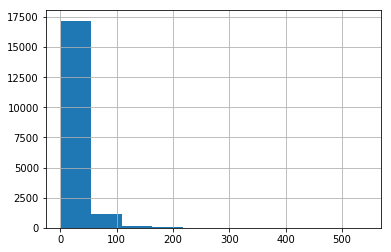

In [20]:
df_inv_summary["StockCodecount"].hist()

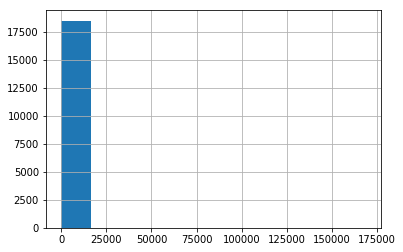

In [22]:
df_inv_summary["ItemTotalsum"].hist()

## Aggregate Customers
Let us analyze customers next. To do so we need to aggregate by Customer ID and count invoices and sum the invoice totals. This will tell us the total amount spent by the customer and the number of store visits 

In [23]:

df_freq_cust = df_inv_summary.groupby('CustomerID').\
agg({'ItemTotalsum': ['sum'], 'InvoiceNo':['count']}).reset_index()

## Sample of Customer Aggregation

In [27]:
df_freq_cust.columns = [''.join(col).strip() for col in df_freq_cust.columns]
df_freq_cust.columns = ["CustomerID", "Store_Visits", "Amount_Spent"]
df_freq_cust.head()

,CustomerID,Store_Visits,Amount_Spent
0,12346,1,77183.60
1,12347,7,4310.00
2,12348,4,1797.24
3,12349,1,1757.55
4,12350,1,334.40


## Summarize Customer View

In [28]:
df_freq_cust.describe()

,CustomerID,Store_Visits,Amount_Spent
count,4338.000000,4338.000000,4338.000000
mean,15299.816275,4.270401,2054.228424
std,1722.069938,7.701992,8989.225381
min,12346.000000,1.000000,0.000000
25%,13812.250000,1.000000,307.415000
50%,15298.500000,2.000000,674.485000
75%,16778.750000,5.000000,1661.740000
max,18287.000000,210.000000,280206.020000


## Observations About Customers
- The store enjoys customer loyalty. On average, a customer generates about 5 invoices at the store.
- There are some customer outliers - some very atypical customers. This can be identified by inspecting the maximum values for the store visits and the amount spent

We will confirm these with histogram views for these attributes

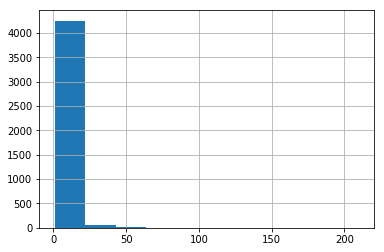

In [29]:
df_freq_cust["Store_Visits"].hist()

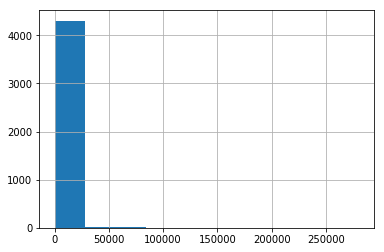

In [30]:
df_freq_cust["Amount_Spent"].hist()

### A View of Atypical Customers
Let's take a look at customers who are atypical. We will define an atypical customer to be one that spends over 3 standard deviations from the mean customer spend at the store. We will first define this threshold


In [31]:
atypical_threshold = df_freq_cust["Amount_Spent"].mean() + 3 * df_freq_cust["Amount_Spent"].std()
df_ob = df_freq_cust[df_freq_cust.Amount_Spent > atypical_threshold]

## Sample of Atypical Customers

In [32]:
df_ob.head()

,CustomerID,Store_Visits,Amount_Spent
0,12346,1,77183.60
55,12415,21,124914.53
326,12748,210,33719.73
453,12931,15,42055.96
562,13089,97,58825.83


## Histogram View of Atypical Customers

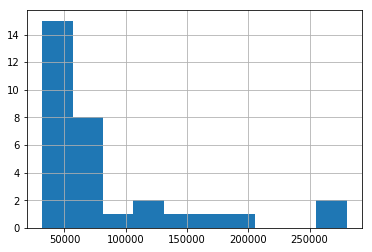

In [33]:
df_ob["Amount_Spent"].hist()

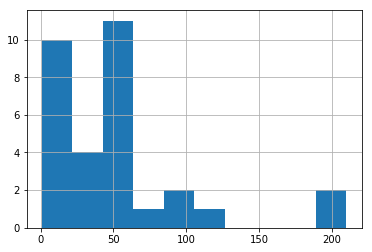

In [34]:
df_ob["Store_Visits"].hist()

## Observations
- Both histograms are skewed and captures the atypical customers. For example there is a customer who spends over 250 K at the store and there is a customer who has generated over 200 invoices at the store.

In [ ]:
df.columns

In [ ]:
df.groupby("CustomerID")